In [7]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')
#from src.inference.models import LineDetector
from src.segmentation.gcn_model import GCN
from src.data.dataset_line_rider import DatasetLineRider
from src.data.dataset_inference import DatasetInference
from src.utils.distances import get_median_diff, d2, get_smallest_distance

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [8]:
import numpy as np
import cv2
import torch


class LineDetector:
    """
    Loads the line rider model for inference.
    """
    def __init__(self, config: dict):
        line_rider_weights = config['line_rider']['weights']
        line_finder_weights = config['line_finder']['weights']
        self.device_lr = torch.device('cuda:' + str(config['line_rider']['device']) if torch.cuda.is_available() else 'cpu')
        self.device_lf = torch.device('cuda:' + str(config['line_finder']['device']) if torch.cuda.is_available() else 'cpu')
        num_classes = config['line_finder']['num_classes']
        backbone = config['line_finder']['backbone']

        print('## Load Line Rider:')
        self.line_rider = self.load_line_rider_model(line_rider_weights, self.device_lr)
        print('## Load Line Finder:')
        self.line_finder_seg = self.load_line_finder_model(line_finder_weights, self.device_lf, num_classes, backbone)
        print('## Loaded!')


    def load_line_rider_model(self, weights, device):
        model = torch.load(weights, map_location=device)
        model.to(device)
        model.eval()
        model.device = device

        return model

    def load_line_finder_model(self, weights, device, num_classes, backbone):
        seg_model = GCN(n_classes=num_classes, resnet_depth=backbone)
        seg_model.load_state_dict(torch.load(weights, map_location=device))
        seg_model.to(device)
        seg_model.eval()

        return seg_model

    def segmentation_postprocessing(self, array: np.array, sigma, threshold, morph_close_size, erode_size):
        out = cv2.GaussianBlur(array, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
        out = (out > threshold) * 1.0
        out = cv2.morphologyEx(out, cv2.MORPH_CLOSE, (morph_close_size, morph_close_size))
        out = cv2.erode(out, (erode_size, erode_size), iterations=1)

        return out

    def extract_start_points_and_angles(self, seg: np.array) -> tuple:
        segmentation = np.transpose(seg[0], (1,2,0))

        probs_start_points = segmentation[:, :, 2]
        probs_end_points = segmentation[:, :, 3]
        probs_baselines = segmentation[:, :, 0]

        # Postprozessing parameters
        sigma = 0.3
        threshold = 0.95
        morph_close_size = 3
        erode_size = 3

        # Extract start points
        sp = self.segmentation_postprocessing(probs_start_points, sigma, threshold, morph_close_size, erode_size)
        _, _, _, start_points = cv2.connectedComponentsWithStats(sp.astype(np.uint8))

        # Extract end points
        ep = self.segmentation_postprocessing(probs_end_points, sigma, threshold, morph_close_size, erode_size)
        _, _, _, end_points = cv2.connectedComponentsWithStats(ep.astype(np.uint8))

        # Compute the angles and match start and end points
        probs_sum = probs_start_points + probs_end_points + probs_baselines
        ps = cv2.GaussianBlur(probs_sum, (int(3 * sigma) * 2 + 1, int(3 * sigma) * 2 + 1), sigma)
        ps = (ps > threshold) * 1.0
        ps = cv2.morphologyEx(ps, cv2.MORPH_OPEN, (3, 3))

        _, labels, stats, _ = cv2.connectedComponentsWithStats(ps.astype(np.uint8))

        # stats is a matrix where for every label l the vector stats[l] is given by:
        # [leftmost (x) coordinate, topmost (y) coordinate, width of bounding box, height of bouinding box, area]
        # see https://stackoverflow.com/questions/35854197/how-to-use-opencvs-connected-components-with-stats-in-python

        # Assign labels to the start and end points
        # [1:] because the background is also a component
        sp_labels = {labels[(int(p[1]), int(p[0]))]: p for p in start_points[1:]}
        ep_labels = {labels[(int(p[1]), int(p[0]))]: p for p in end_points[1:]}

        label_list = sp_labels.keys()
        angles = {l: np.arctan(stats[l][3] / stats[l][2]) for l in label_list}

        return sp_labels, ep_labels, angles, label_list

    def extract_baselines(self, image: torch.tensor):
        image = image.unsqueeze(0).to(self.device_lf)
        seg_out = self.line_finder_seg(image)[0]

        image_seg = torch.cat([image[:, 0:1, :, :], seg_out[:, [0, 1], :, :]], dim=1).detach()
        
        start_points, end_points, angles, label_list = self.extract_start_points_and_angles(seg_out.cpu().detach().numpy())

        sp_values = torch.tensor(list(start_points.values())).to(self.device_lr)

        baselines = []
        ep_label_list = end_points.keys()

        for l in label_list:
            sp = torch.tensor(start_points[l]).to(self.device_lr)
            angle = torch.tensor(angles[l]).to(self.device_lr)

            # Compute box size
            box_size = int(get_smallest_distance(sp, sp_values))
            box_size = max(10, min(48, box_size))
            if box_size == 0:
                box_size = min(10, max(32, get_median_diff(start_points) / 2.0))

            box_size = torch.tensor(box_size).double()

            if l in ep_label_list:
                ep = torch.tensor(end_points[l]).to(self.device_lr)

                baseline, _, _, _ = self.line_rider(img=image_seg, box_size=box_size, sp=sp, ep=ep, angle_0=angle)

            baselines.append(baseline)

        return baselines

In [9]:
line_rider_weights = os.path.join('..', 'trained_models', 'line_rider', 'line_rider_seg_2.pt')
line_finder_weights = os.path.join('..', 'trained_models', 'segmentation', 'GCN_1024_cBAD_resnext50.pt')
device_lr = 'cpu'
device_lf = 'cpu'

parameters = {'input_folder': os.path.join('..', 'data', 'inference'),
              'max_side': 1024,
              'crop_size': None}

config = {
  "line_rider": {
    "weights": "..\\trained_models\\line_rider\\line_rider_seg_2.pt",
    "device": 1
  },
  "line_finder": {
    "weights": "..\\trained_models\\segmentation\\GCN_1024_cBAD_resnext50.pt",
    "device": 1,
    "num_classes": 6,
    "backbone": 50
  },
  "random_seed": 42,
  "output_folder": "..\\data\\inference_out",
  "data": {
    "input_folder": "..\\data\\inference",
    "img_size": 1024
  }
}

In [10]:
ld = LineDetector(config)

## Load Line Rider:


c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'src.model.line_rider.LineRider' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## Load Line Finder:
## Loaded!


In [11]:
ds = DatasetInference(1024, os.path.join('..', 'data', 'inference'))

In [35]:
sample = ds[0]

In [36]:
image = sample['image'].unsqueeze(0)
seg_out = ld.line_finder_seg(image)[0][0]

In [37]:
sample['filename']

'..\\data\\inference\\cPAS-0003.jpg'

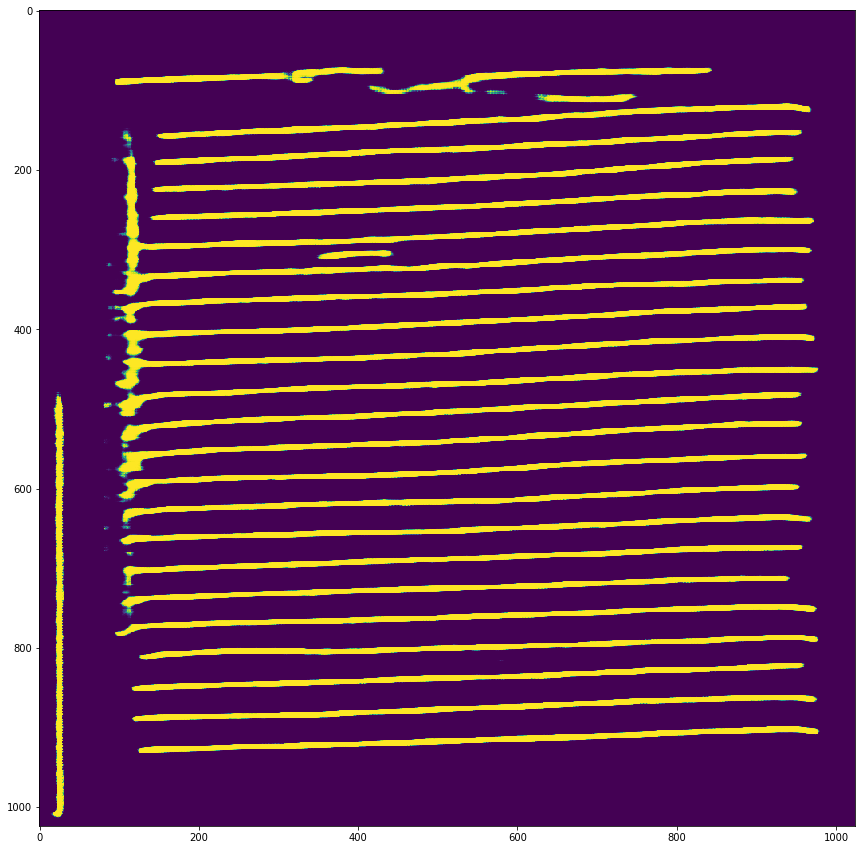

In [38]:
plt.figure(figsize=(15,15))
plt.imshow(seg_out[0,:,:].detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


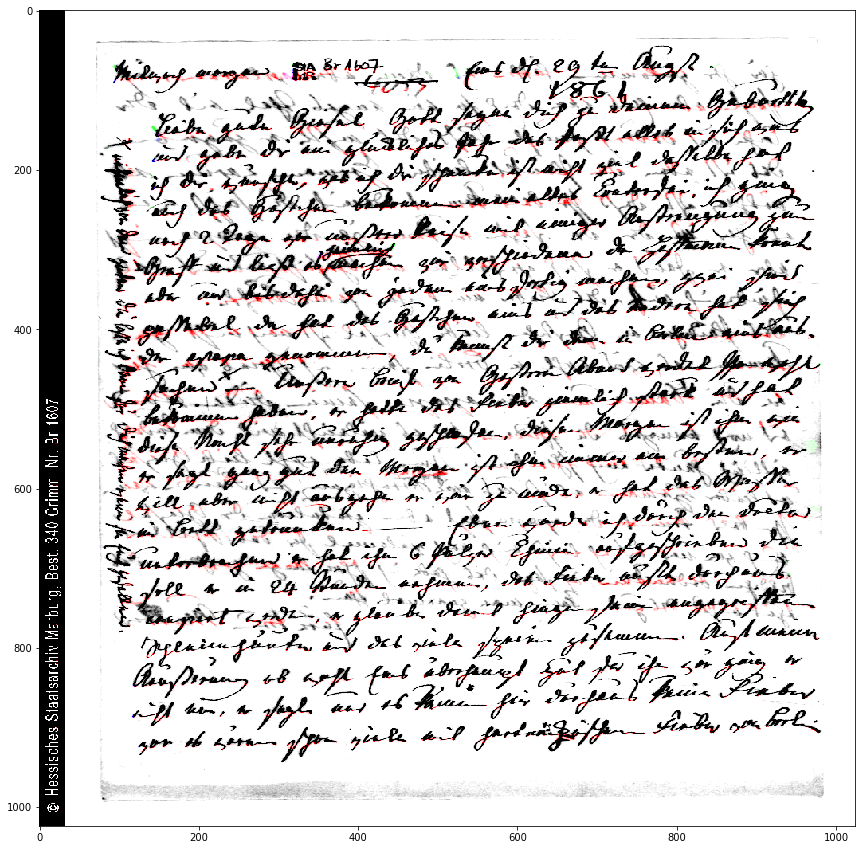

In [39]:
plt.figure(figsize=(15,15))
plt.imshow(image[0].permute(1,2,0).detach().numpy() + seg_out[0:3,:,:].permute(1,2,0).detach().numpy())

In [25]:
start_points, end_points, angles, label_list = ld.extract_start_points_and_angles(seg_out.unsqueeze(0).detach().numpy())

In [32]:
len(list(start_points.values()))

31

In [27]:
sp_list = []

for l in start_points.keys():
    sp_list.append(start_points[l])

In [30]:
sp_t = torch.tensor(sp_list)

In [32]:
get_smallest_distance(sp_t[0], sp_t)

tensor(40.1270, dtype=torch.float64)

In [34]:
torch.pow(torch.tensor(2), 2)

tensor(4)

In [33]:
start_points

{2: array([165.32258065,  66.5483871 ]),
 3: array([829.92361111,  68.04861111]),
 4: array([162.02325581, 107.72868217]),
 5: array([157.78947368, 137.86842105]),
 6: array([154.75490196, 170.29411765]),
 7: array([159.57364341, 197.46511628]),
 8: array([162.49655172, 225.53103448]),
 9: array([165.848, 253.68 ]),
 10: array([167.26515152, 282.62878788]),
 11: array([165.59854015, 314.86861314]),
 12: array([171.82539683, 346.63492063]),
 13: array([171.52307692, 379.9       ]),
 15: array([174.09803922, 406.52941176]),
 16: array([174.0137931 , 438.35862069]),
 17: array([179.12592593, 468.25185185]),
 18: array([179.76760563, 497.9084507 ]),
 19: array([175.68217054, 531.80620155]),
 20: array([181.94160584, 562.42335766]),
 21: array([185.79020979, 592.67132867]),
 22: array([183.38235294, 626.11764706]),
 23: array([189.71428571, 653.26190476]),
 24: array([193.92307692, 683.13076923]),
 25: array([186.3539823 , 714.09734513]),
 26: array([189.98425197, 745.28346457]),
 27: array

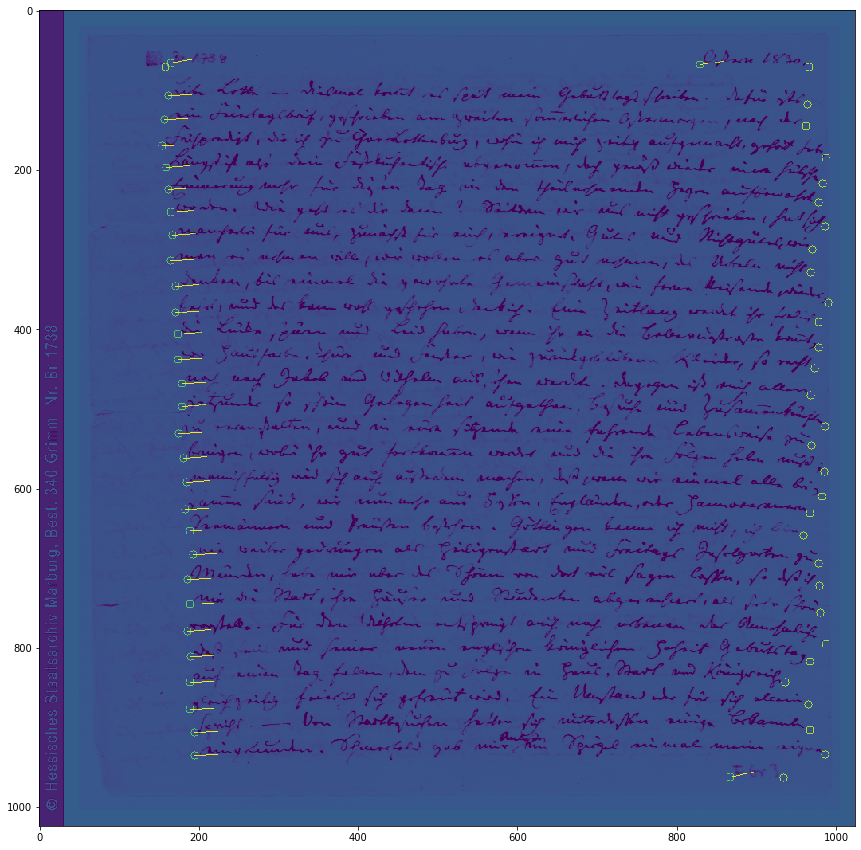

In [34]:
mask_img = np.zeros(image[0,0].shape, dtype=np.uint8)

for l in label_list:
    p = tuple(start_points[l].astype(int))
    cv2.circle(mask_img, p, radius=5, color=8, thickness=1, lineType=8, shift=0)
    angle = angles[l]
    p2 = (int(p[0] + 30*np.cos(angle)), int(p[1] - 30*np.sin(angle)))
    cv2.line(mask_img, p, p2, color=12)
    
    p = end_points[l]
    cv2.circle(mask_img, tuple(p.astype(int)), radius=5, color=10, thickness=1, lineType=8, shift=0)
    
plt.figure(figsize=(15,15))
plt.imshow(mask_img+image[0,0,:,:].detach().numpy())

In [14]:
for x in start_points.values():
    print(x)

[78.5        57.15909091]
[106.84285714  85.56428571]
[478.21167883 102.91240876]
[181.86614173 125.70866142]
[778.01796407 138.03592814]
[109.61111111 211.90277778]
[ 96.65178571 266.66071429]
[ 90.25179856 309.24460432]
[ 87.07258065 355.72580645]
[ 89.90344828 408.57931034]
[ 93.25899281 455.75539568]
[ 81.07142857 511.49107143]
[ 81.47619048 561.95238095]
[ 86.30894309 610.21138211]
[ 88.34693878 655.51020408]
[ 89.79439252 707.6635514 ]
[ 82.54263566 761.2248062 ]
[ 86.48648649 807.59459459]
[ 94.83333333 859.2       ]
[ 79.69158879 920.85981308]


In [193]:
x = torch.tensor(100.12)

In [195]:
if x > 0:
    print(min(x, 2000))

tensor(100.1200)


In [196]:
int(x)

100

In [1]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')
from src.data.dataset_inference import DatasetInference

In [2]:
config = {
  "line_rider": {
    "weights": None,
    "device": 1
  },
  "line_finder": {
    "weights": None,
    "device": 2,
    "num_classes": 6,
    "backbone": 50
  },
  "random_seed": 42,
  "data": {
    "input_folder": os.path.join('..', 'data', 'cBAD-ICDAR2019', 'test'),
    "img_size": 1024
  }
}

In [3]:
di = DatasetInference(1024, os.path.join('..', 'data', 'cBAD-ICDAR2019', 'test'))

In [6]:
for _ in di:
    print(_.shape)

torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])


KeyboardInterrupt: 

In [7]:
import numpy as np

In [10]:
x = np.random.rand(2,3,4)

In [12]:
np.transpose(x, (1,2,0))

array([[[0.79629695, 0.15305811],
        [0.94660926, 0.50113758],
        [0.03689997, 0.67762403],
        [0.38105483, 0.87856163]],

       [[0.24569649, 0.64895862],
        [0.88576822, 0.02137042],
        [0.62252315, 0.87418238],
        [0.61867485, 0.17186353]],

       [[0.92601888, 0.5999389 ],
        [0.16100304, 0.74338019],
        [0.54713229, 0.28786164],
        [0.16136246, 0.01673293]]])

In [16]:
import torch

In [13]:
x.shape

(2, 3, 4)

In [17]:
torch.tensor(x)

tensor([[[0.7963, 0.9466, 0.0369, 0.3811],
         [0.2457, 0.8858, 0.6225, 0.6187],
         [0.9260, 0.1610, 0.5471, 0.1614]],

        [[0.1531, 0.5011, 0.6776, 0.8786],
         [0.6490, 0.0214, 0.8742, 0.1719],
         [0.5999, 0.7434, 0.2879, 0.0167]]], dtype=torch.float64)

In [21]:
list({'a': 1, 'b': 2}.values())

[1, 2]

In [22]:
fn = os.path.join('data\inference\cPAS-0003.jpg')

In [24]:
os.path.basename(fn).split('.')[0]+'.txt'

'cPAS-0003.txt'

In [48]:
import random

In [50]:
[random.randint(-1,1) for _ in range(20)]

[-1, -1, -1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 0]